
#### Comparing Matrix Profile Model (new approach) to existing anomaly models

References
* https://www.cs.umn.edu/research/technical_reports/view/09-004
* https://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf
* https://towardsdatascience.com/the-matrix-profile-e4a679269692


#### Conclusions and Discussions ####
Martix Profile is a pairwise Euclidean distance of a subsequence to it's nearest neighbor. Discords in MP are calculated for a subsequence of data/a time-period specified by the user using window_size

**Integration in Monitor**
1. Ease of use <br>
    1.a Required user input
        1.a.1 Number of discords per pipeline run: the user will select top-K discords to focus on per run. The number of discords found per run will always be the same
        1.a.2 Window size: the user will [determine an appropriate window size] (#selecting-window-size)
2. What does it mean to set alerts on discords? Top-K discords can or cannot be anomalies
3. Recommended Usage for cetrain data types. Most of the data I've had is ranpid edge change data.

**Matrix Profile analysis for 5 datasets**
1. Azure Temperature Data (Top-15 discords)
window size = 32; data frequency = 1min; analysis period = 32 min
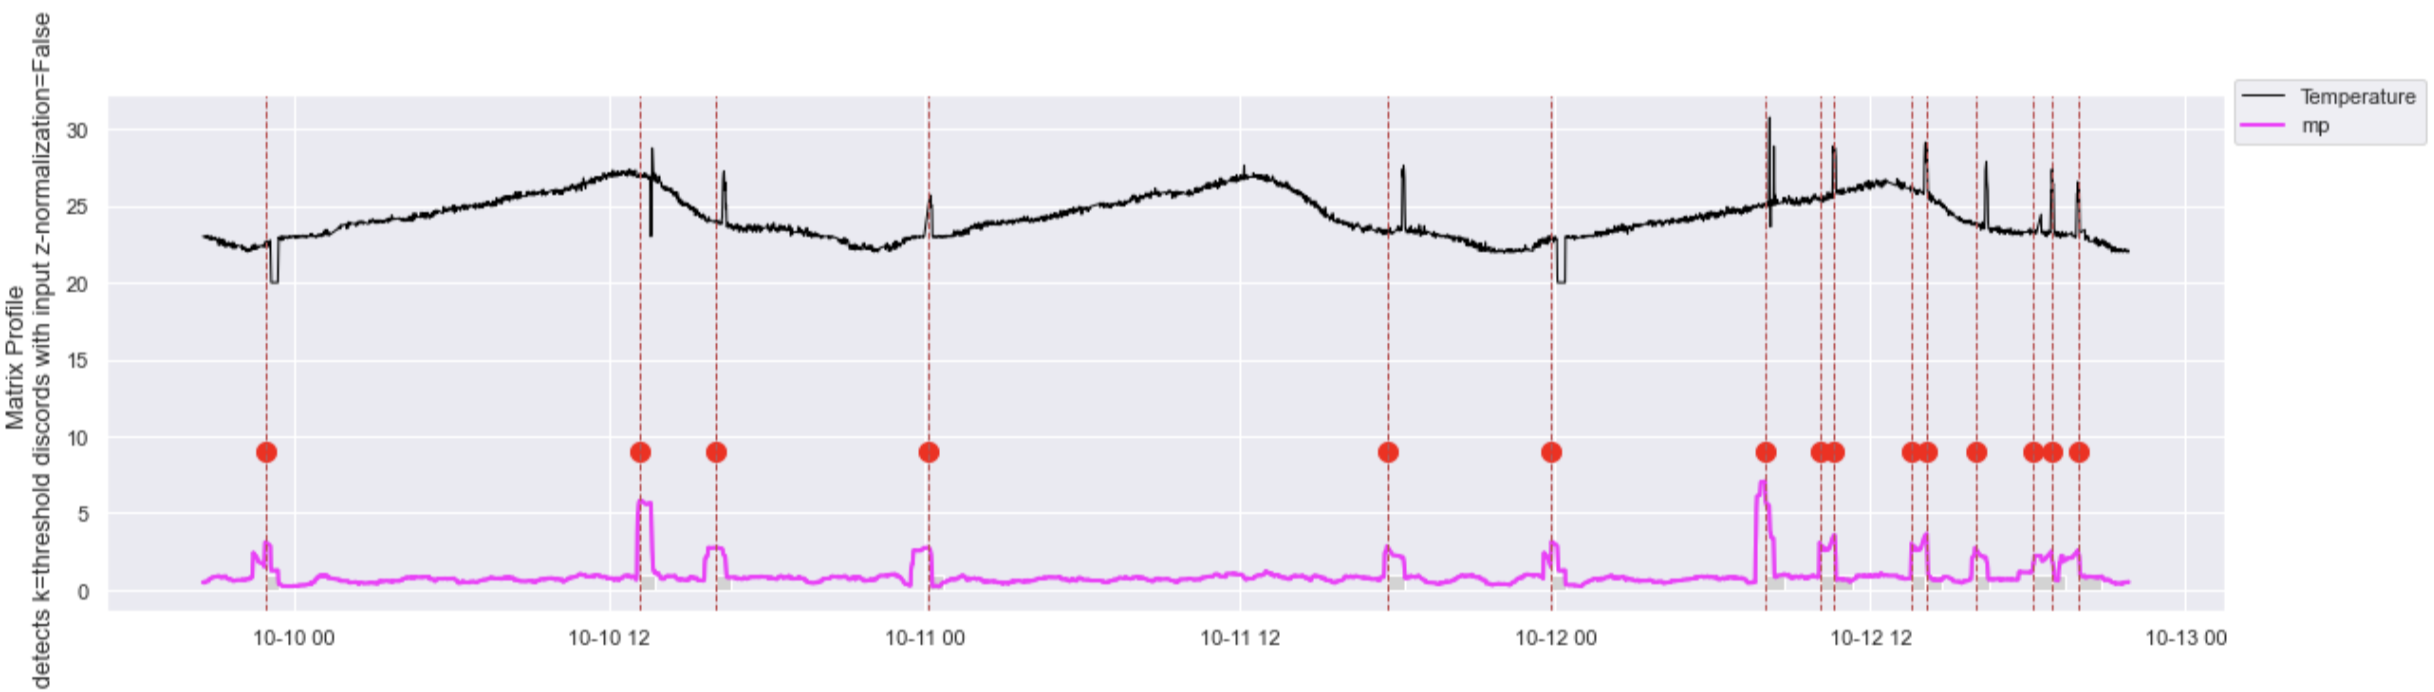

2. Armstark-good Data (Top-5 discords)
window size = 288; data frequency = 5min; analysis period = 24 hours
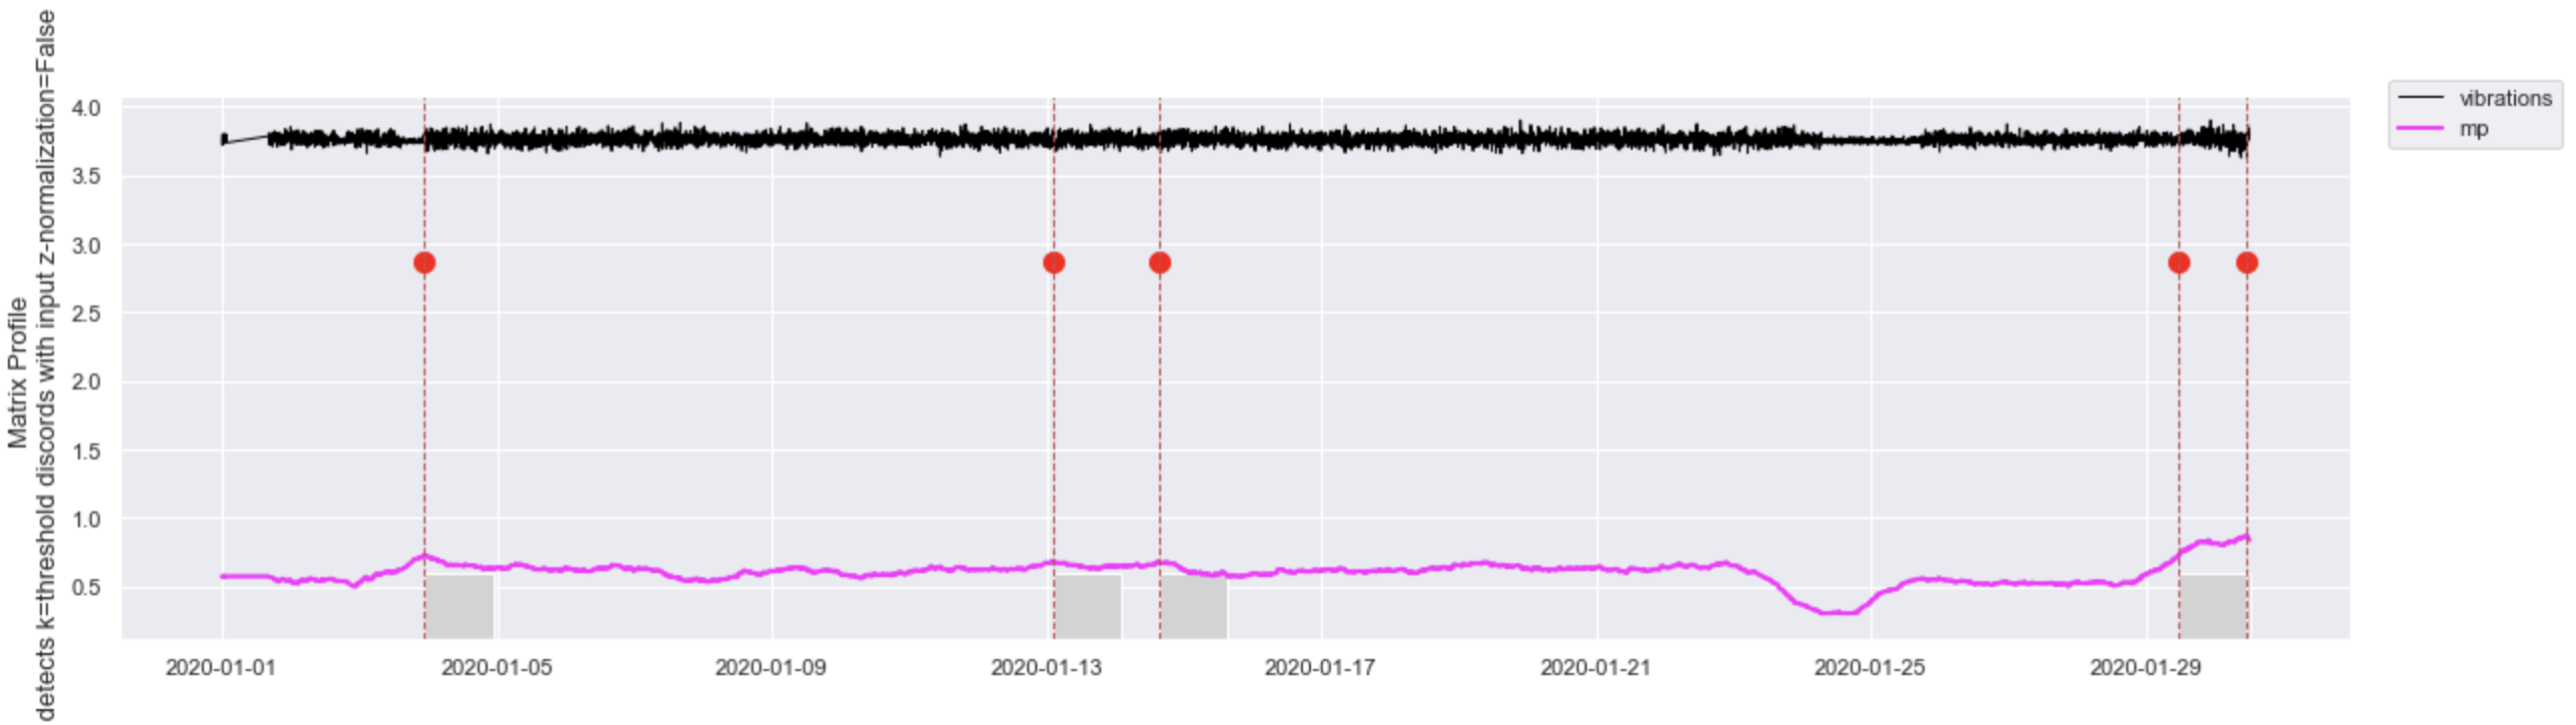

3. Armstark-bad Data (Top-5 discords)
window size = 288; data frequency = 5min; analysis period = 24 hours
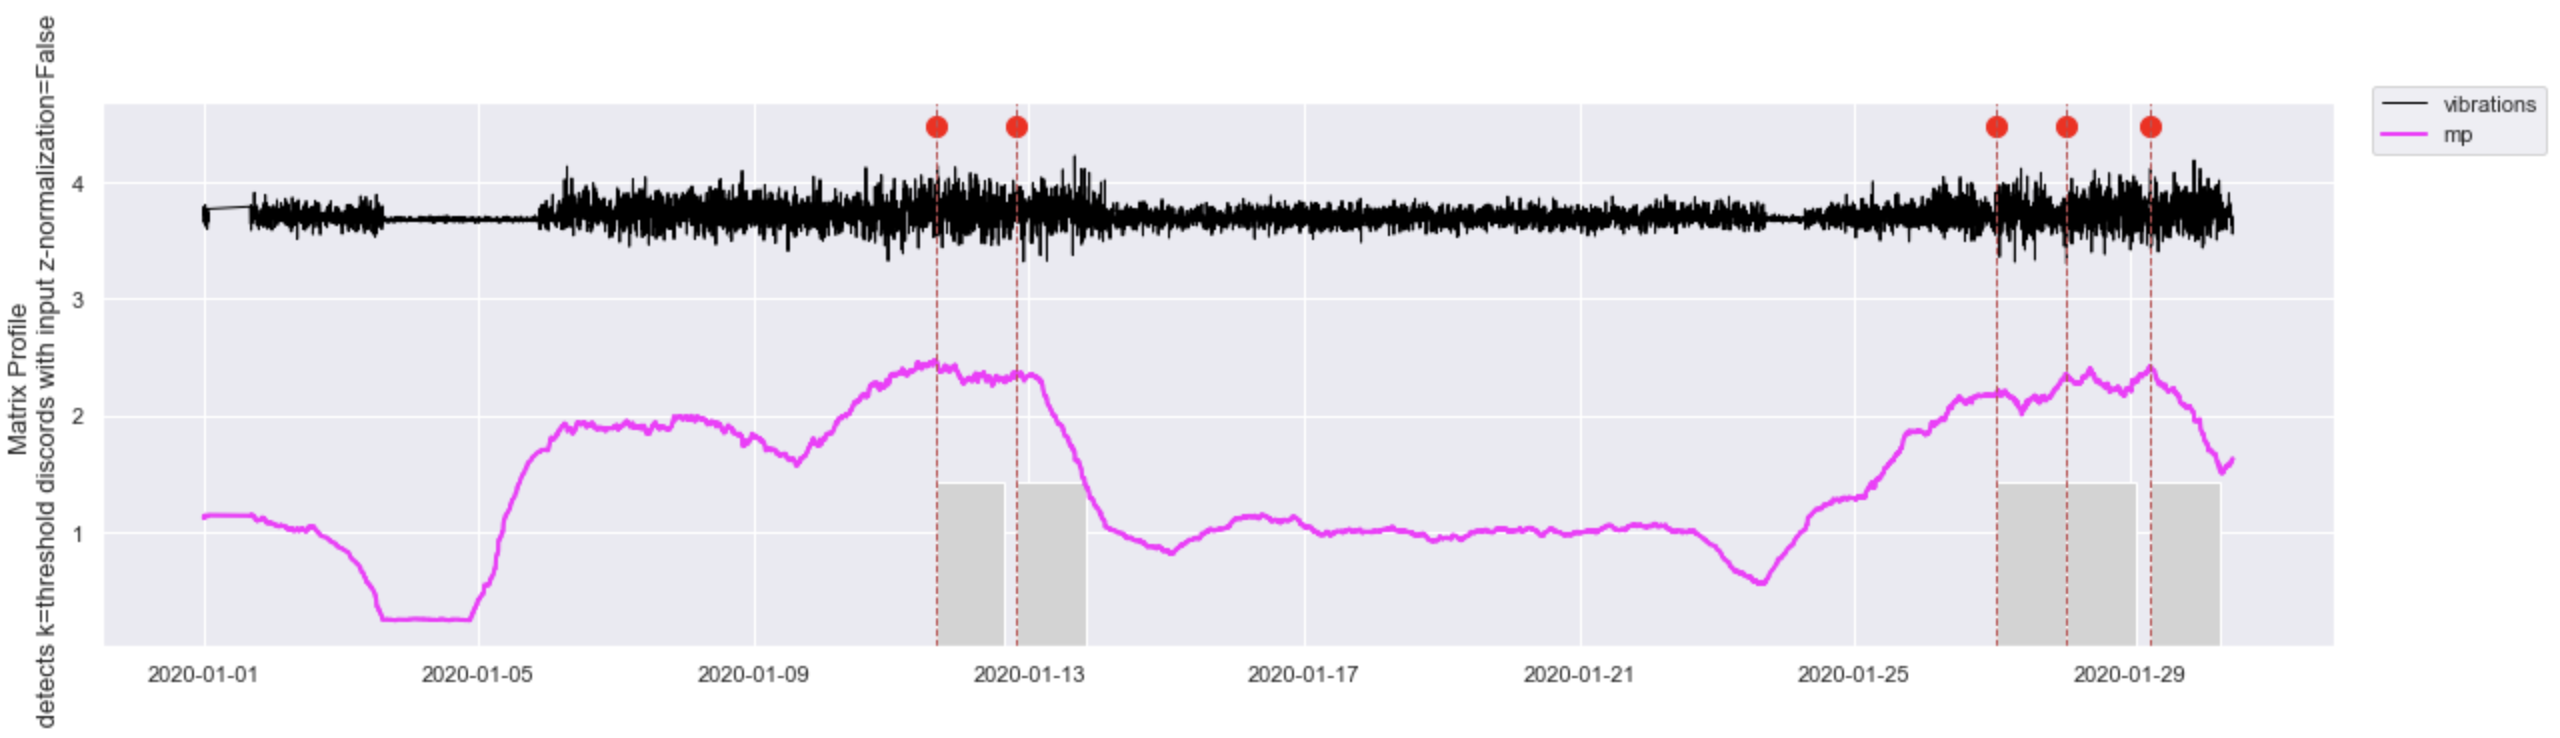

4. Cakebread ID_36 6months Data (Top-5 discords)
window size = 32; data frequency = infrequent
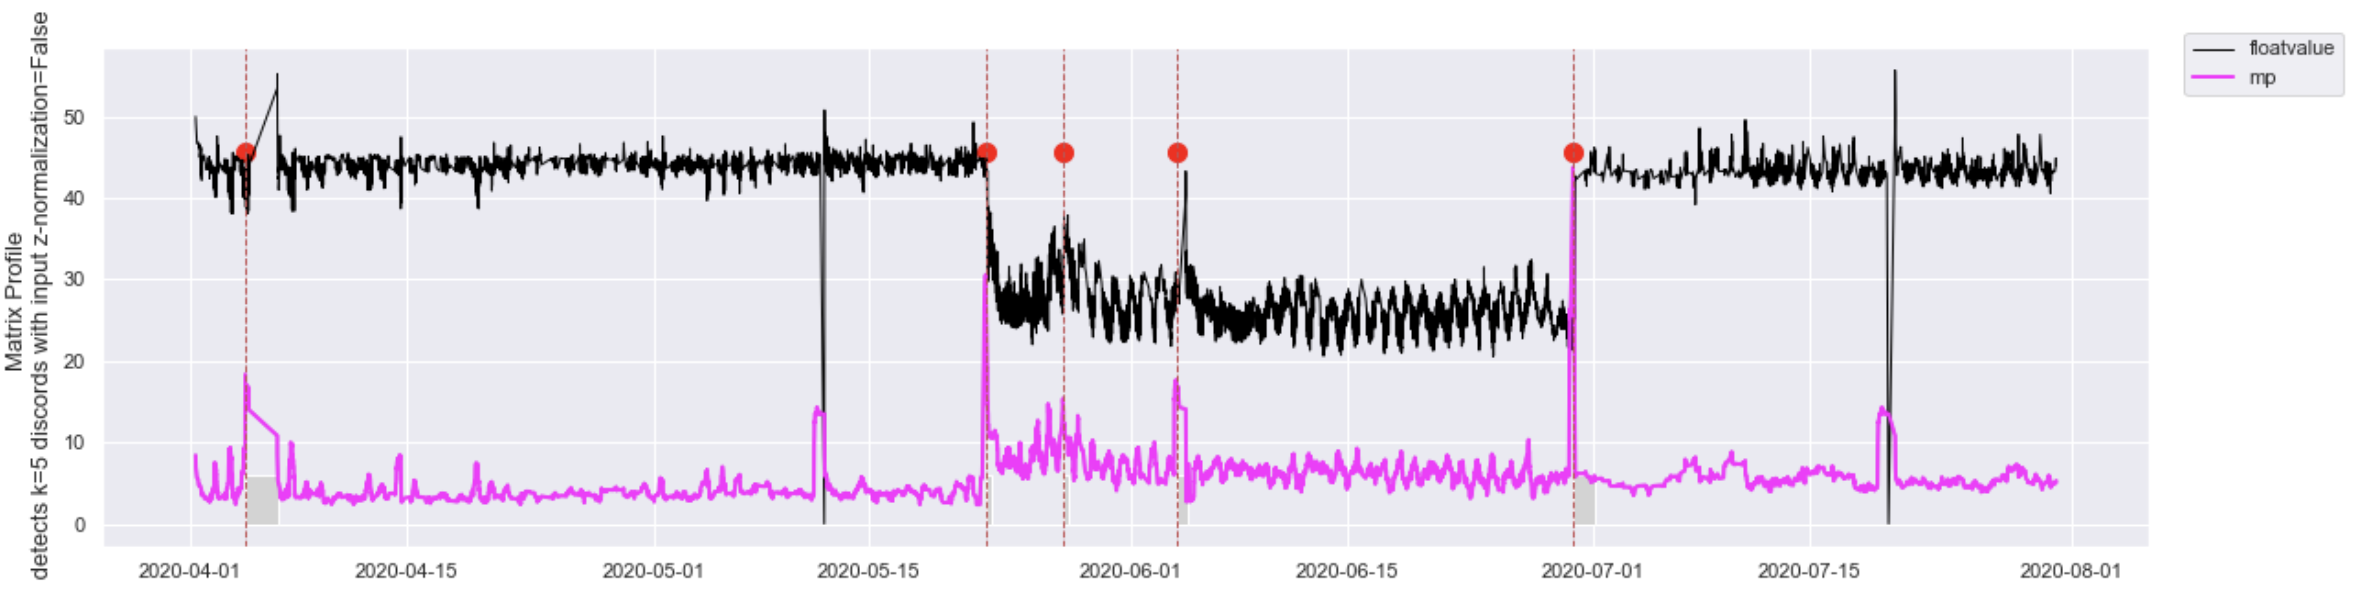

5. Sample Anomaly Data (Top-2 discords)
window size = 32; data frequency = infrequent
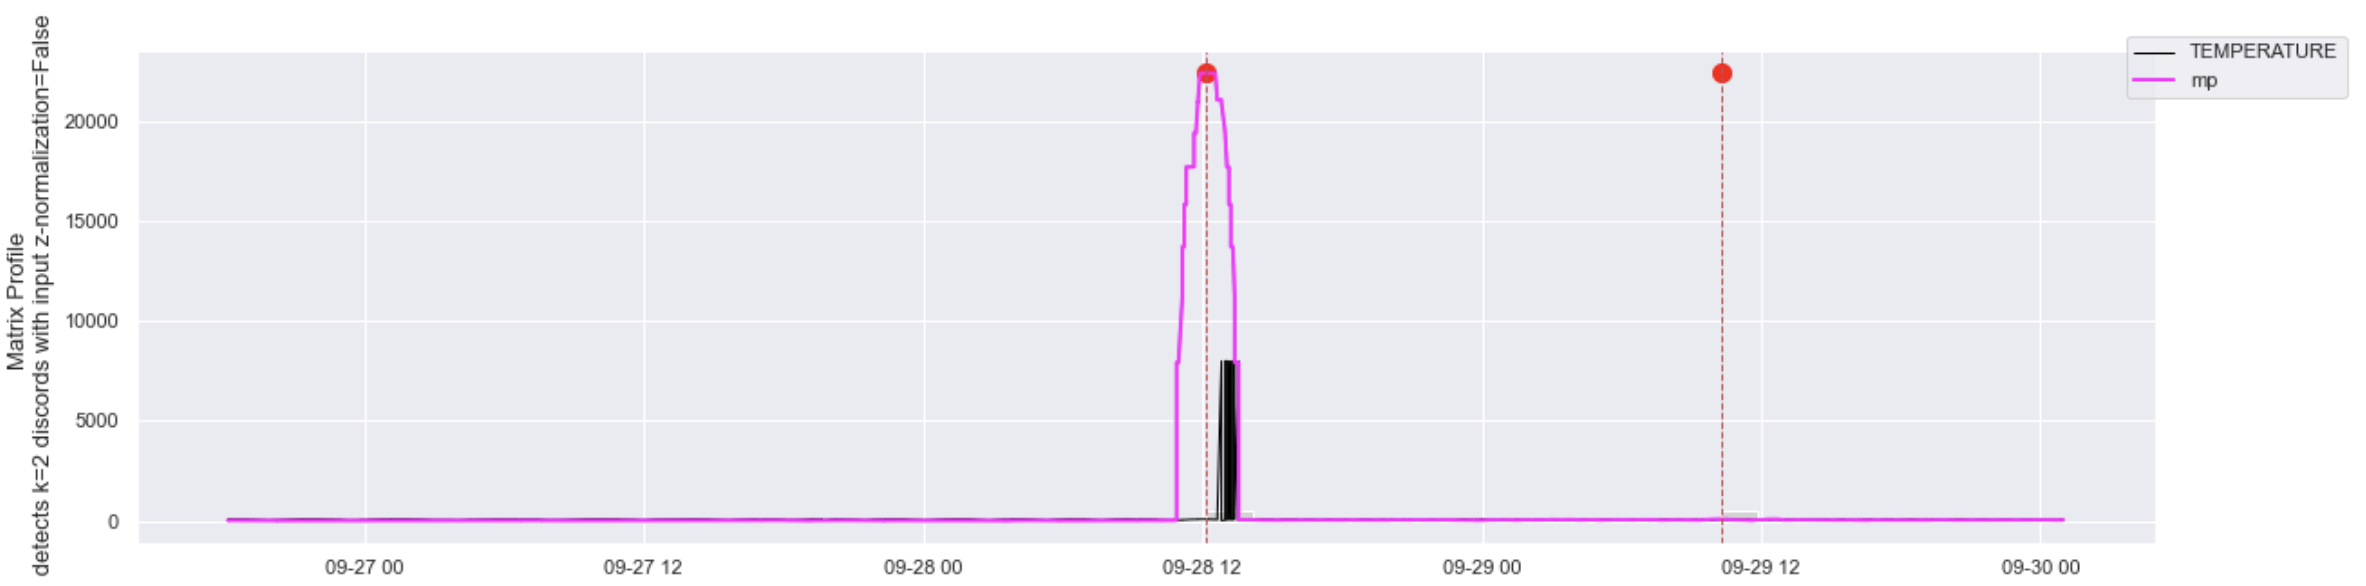

**The effect of window size** <br>
window_size determines the amount of data that forms one subsequece. To choose an appropriate window size the user should know the granurality  of data collection and determine the graularity of analysis. <br>
<a name="selecting-window-size"></a>
*An Example for determining window size: Sensor A is collecting data every 5 min and we want to analyze events for a 24 hour time period*<br>
data_collection_frequency is 5min ; data_analysis_granularity is 1 hour; window_size should be set to 1hour/5min = 60min/5min = 12 <br>
minimum window size can be 3

**The effect of z_nomalization**
1. Azure Temperature Data (Top-15 discords)
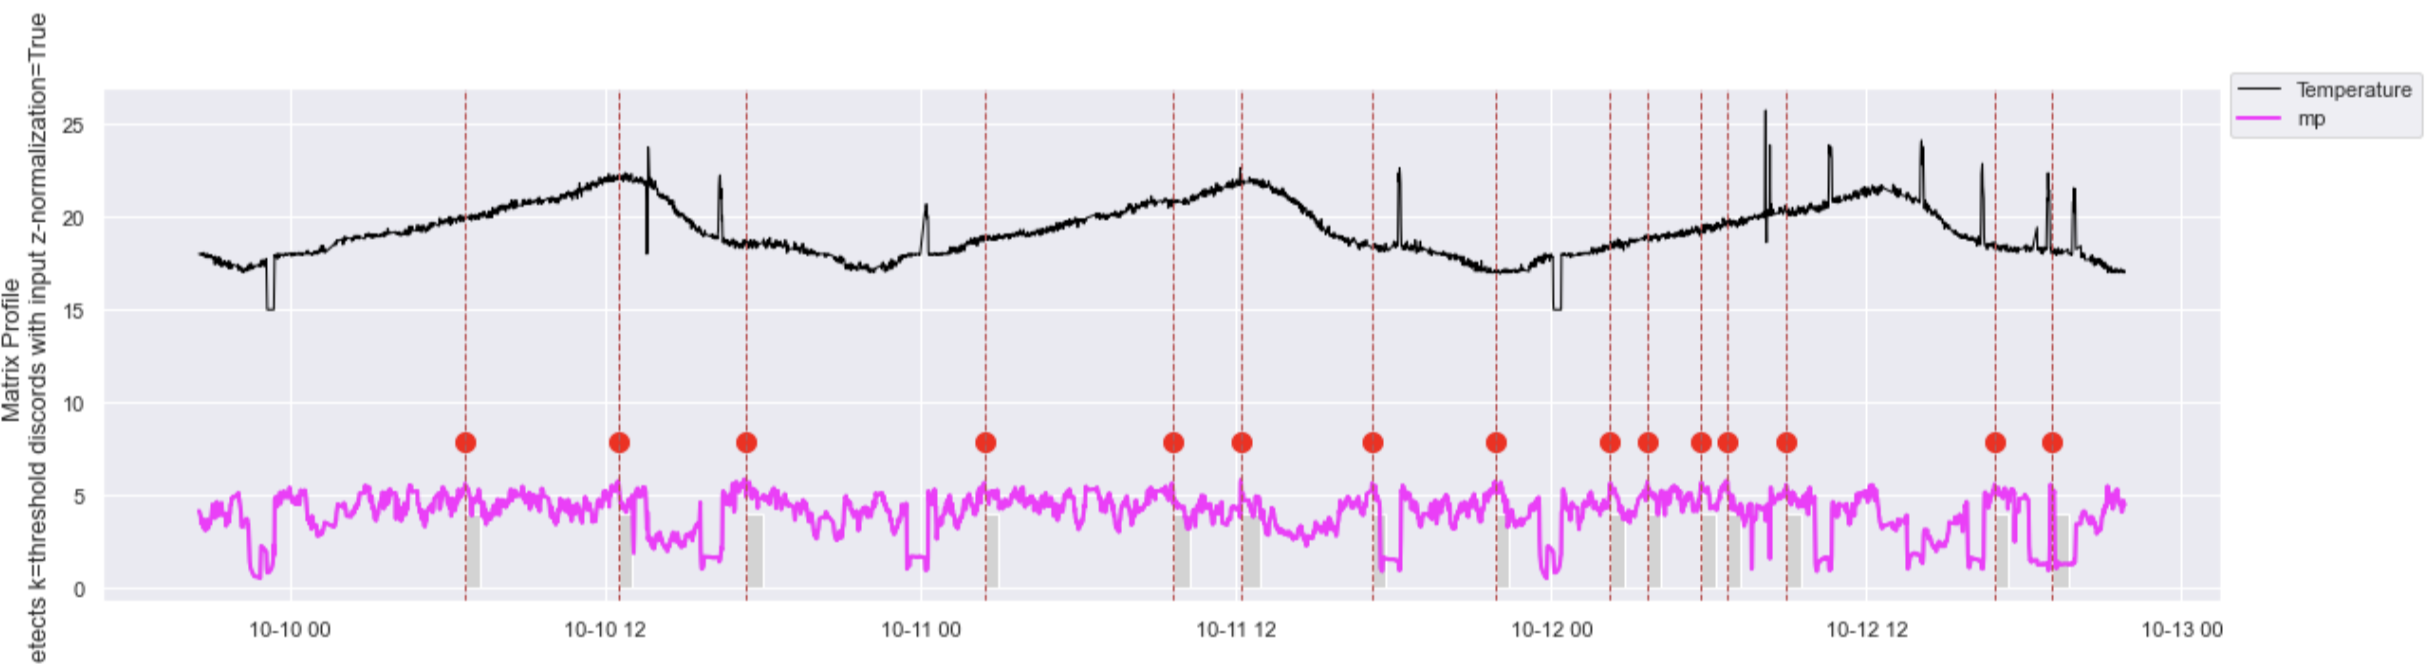
2. Armstark-good Data (Top-5 discords)
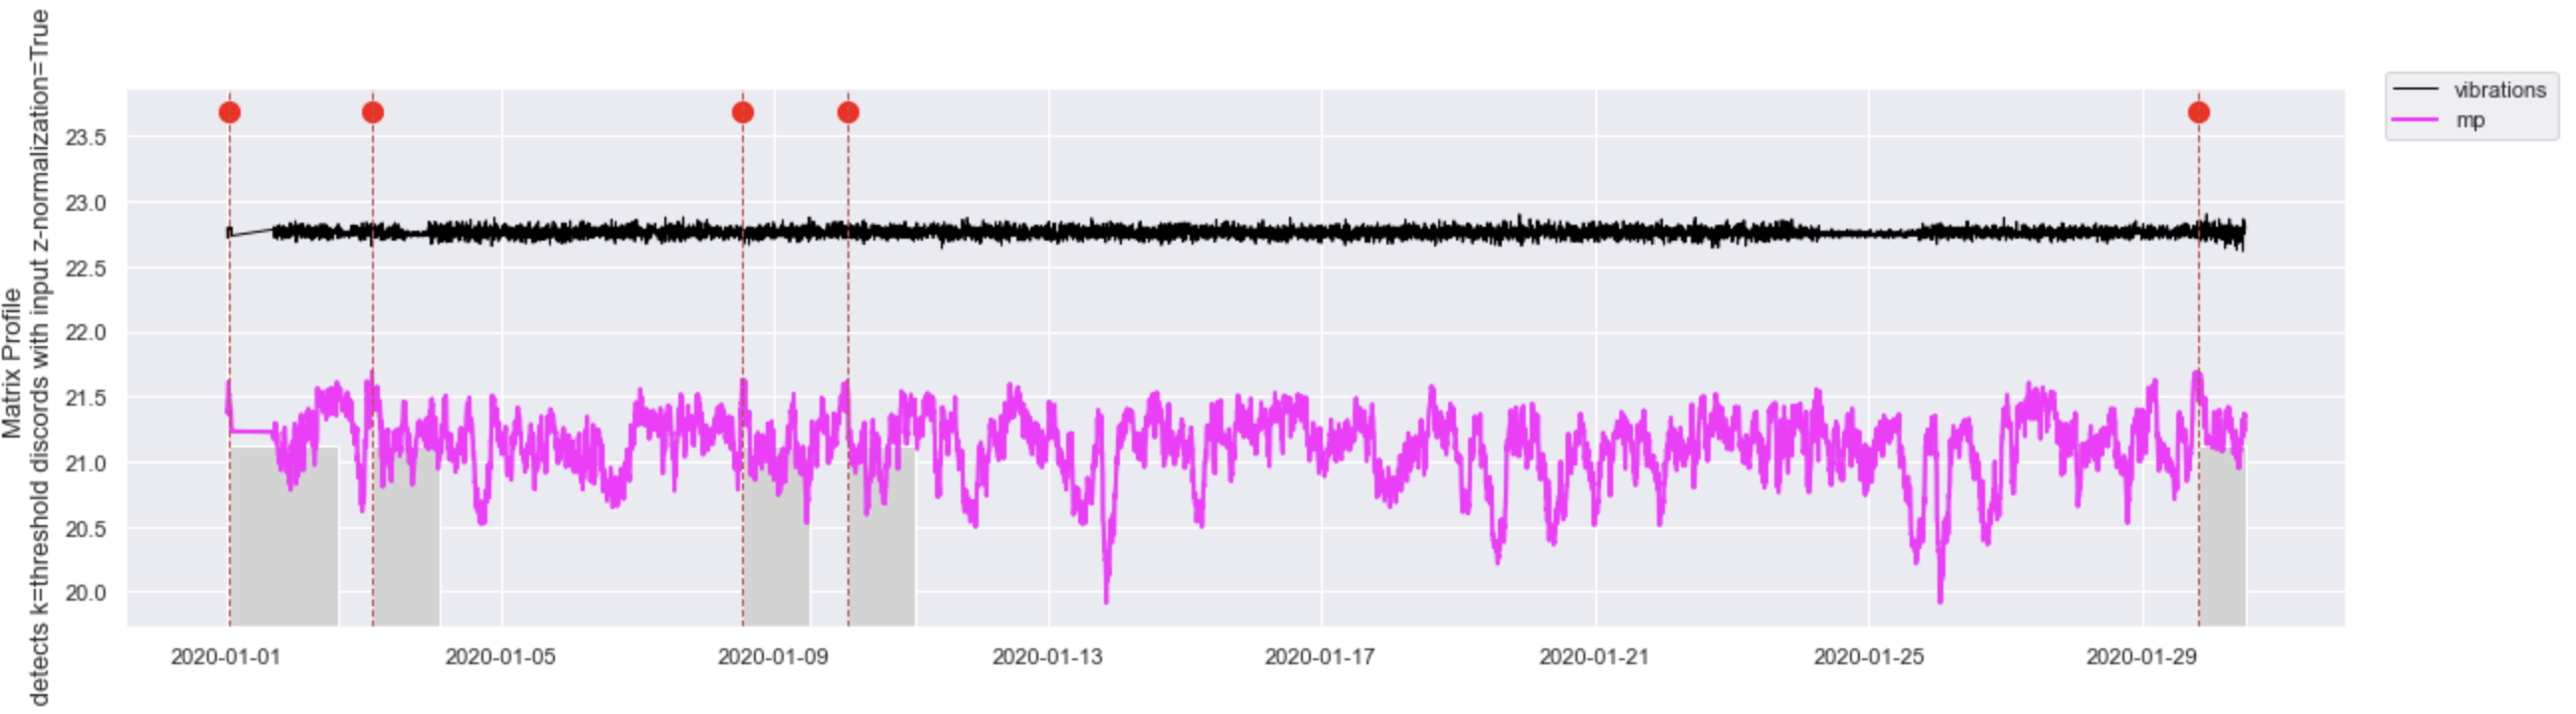
3. Armstark-bad Data (Top-5 discords)
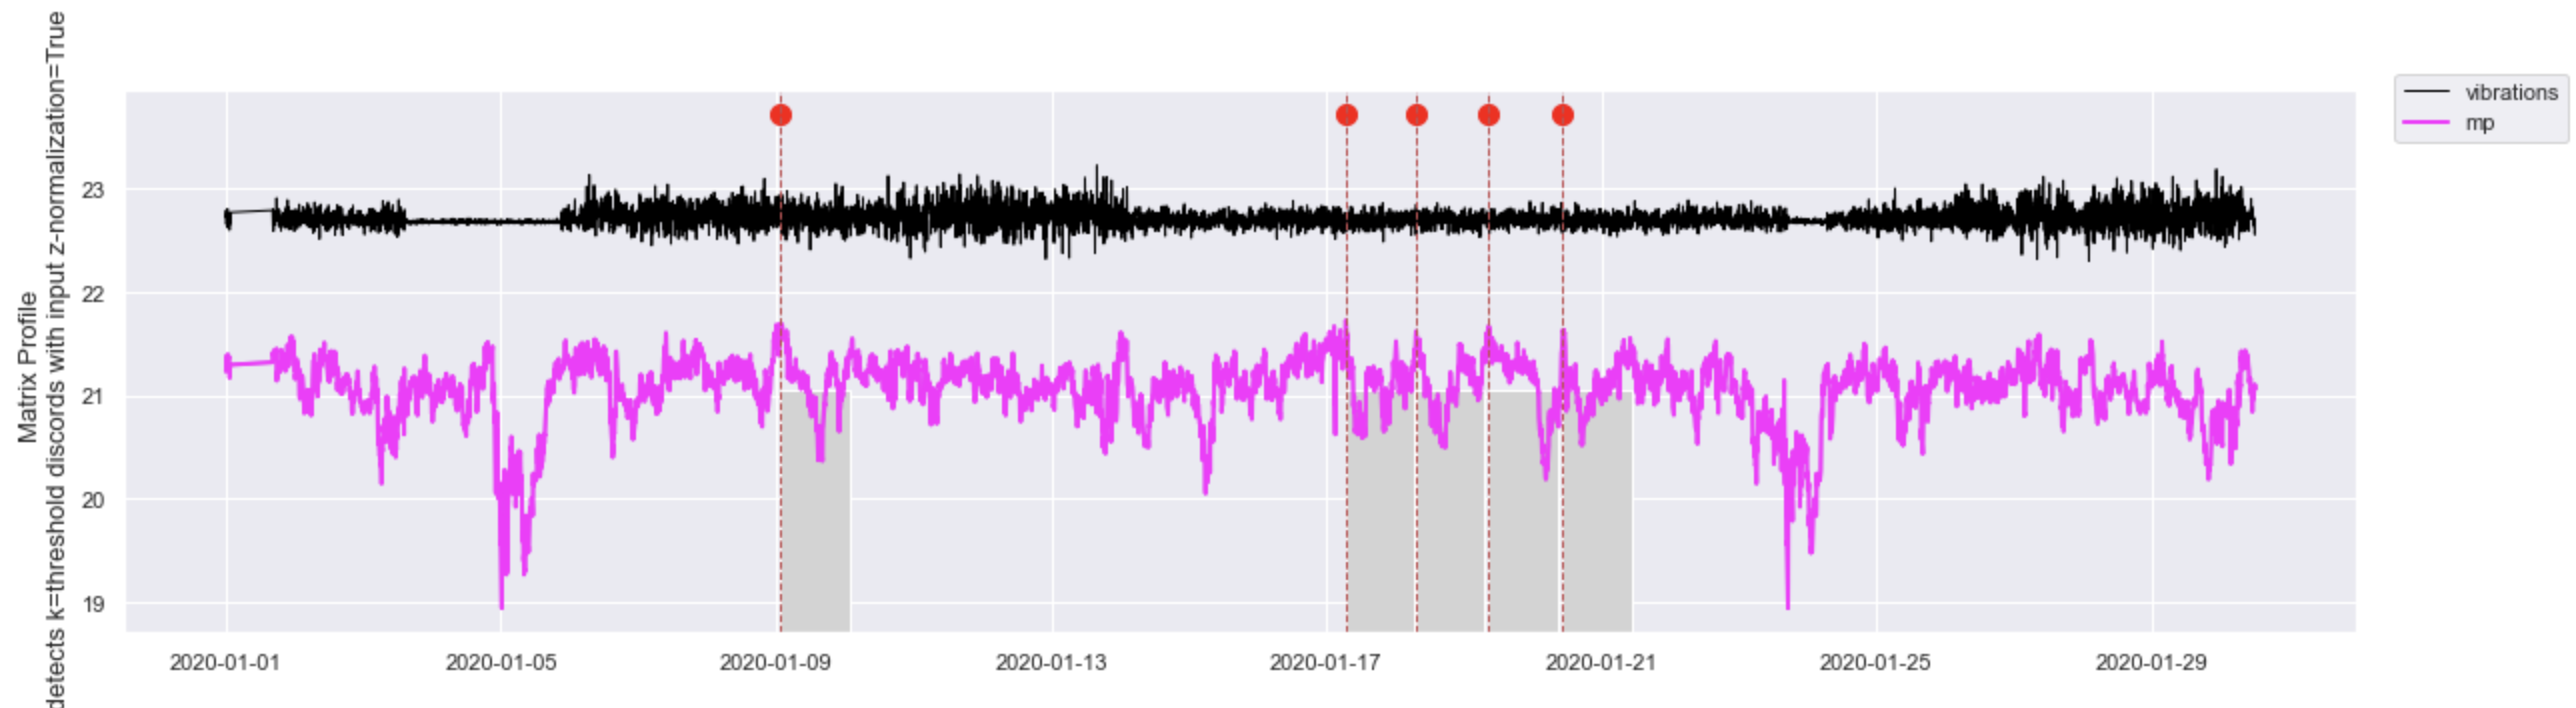
4. Cakebread ID_36 6months Data (Top-5 discords)
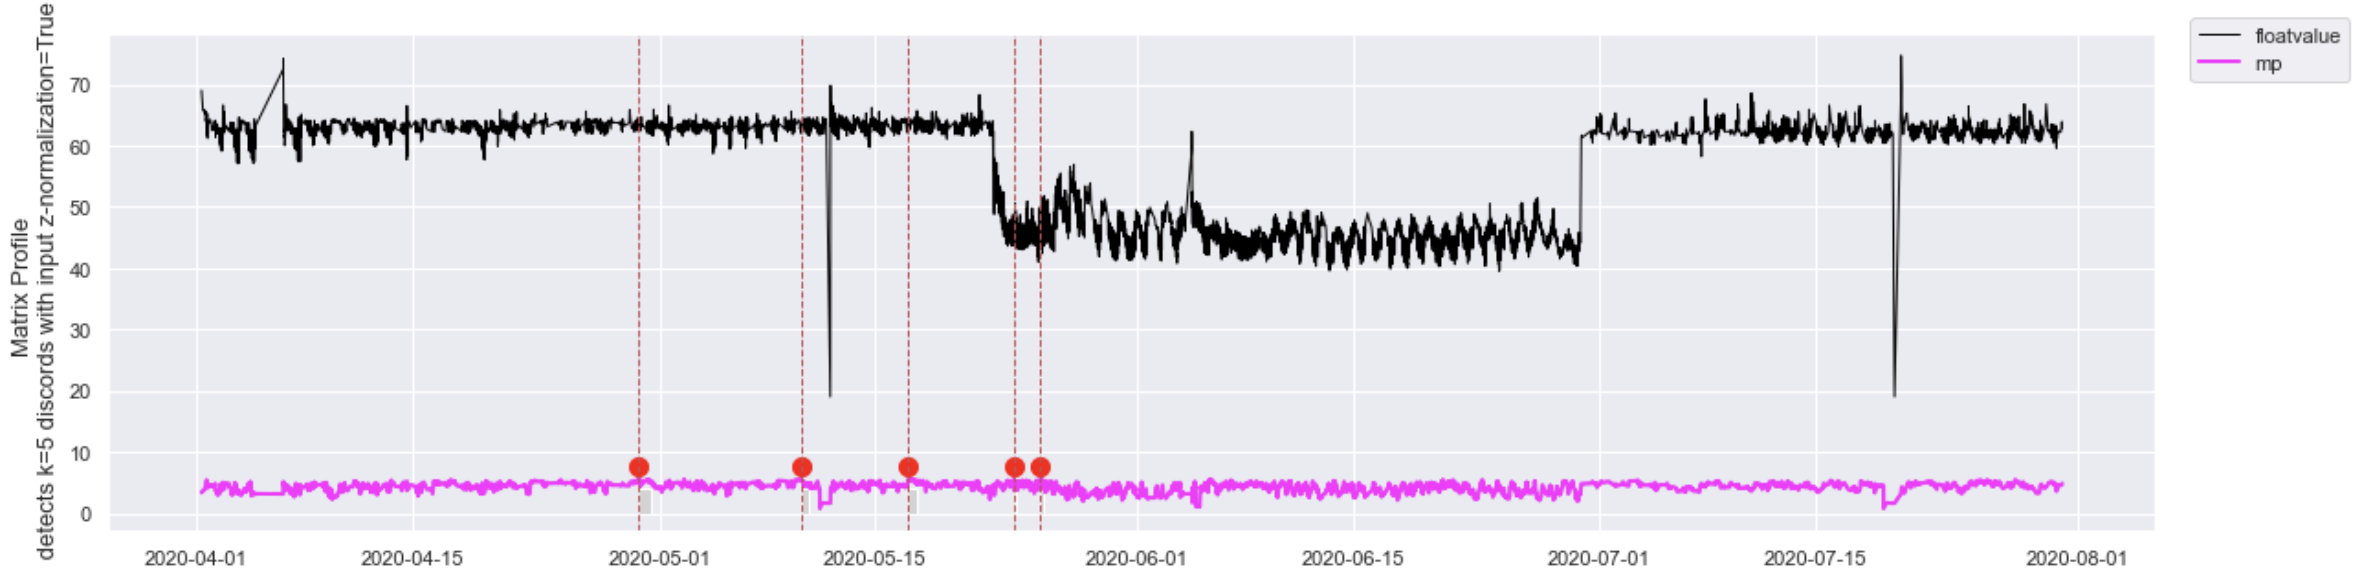
5. Sample Anomaly Data (Top-2 discords)
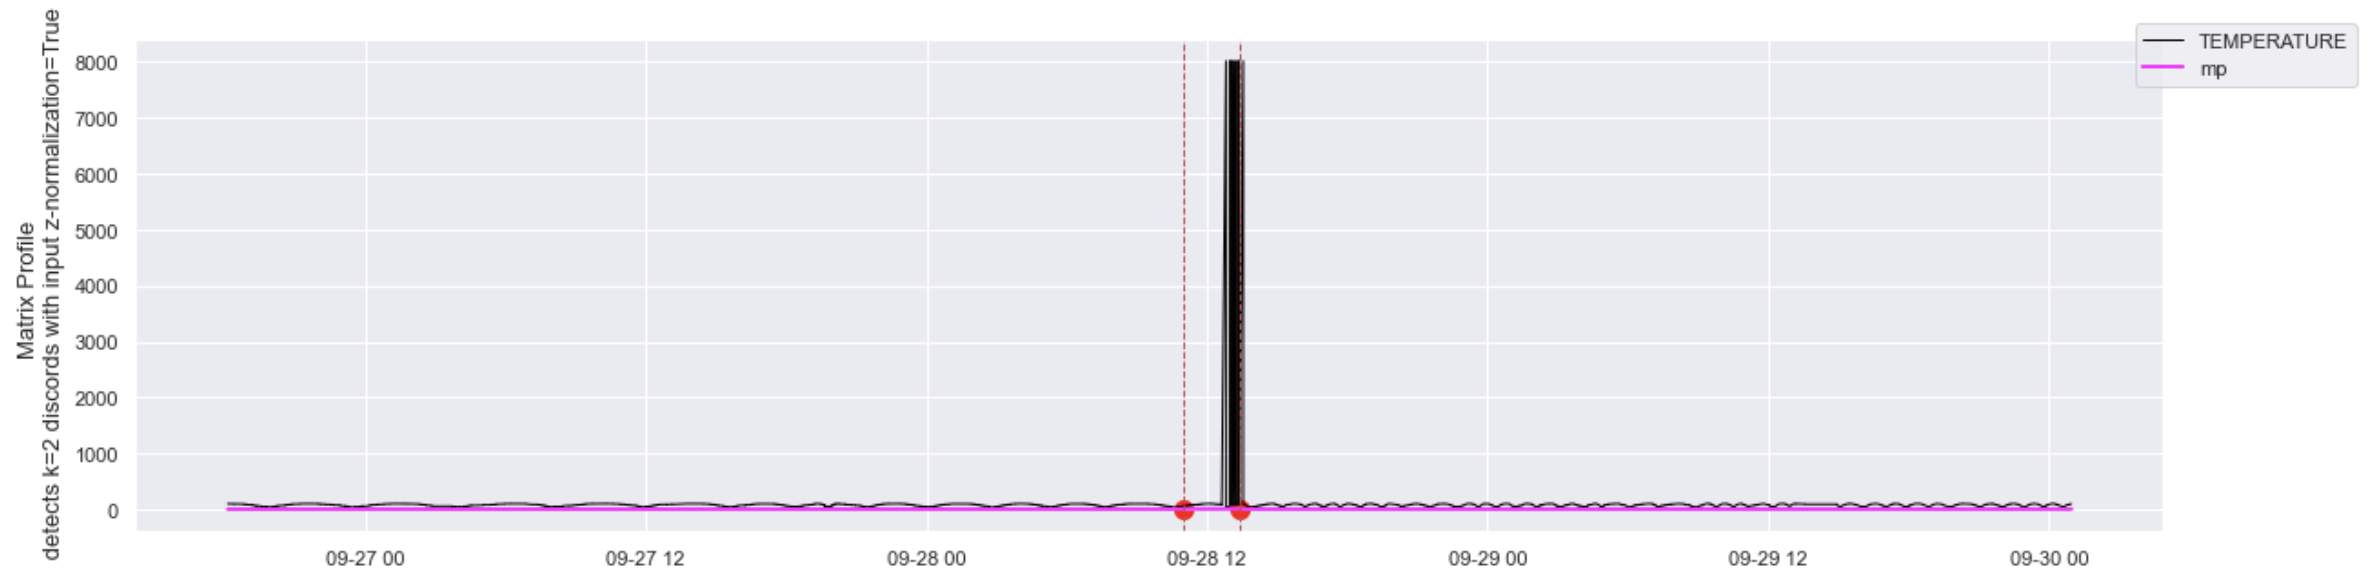

**Comments z_nomalization** <br>
From the experiments using 5 datasets, we've observed that when we z-normalize the datasets before calculating the Matrix Profile, the MP loses the detection of rapid changes in edges. In the non z-normalized version these edges account for most of the discords.
Specifically for Armstark-bad Data we don't detect the flat region because it occurs multiple time in the given window size and shows up as a motif/pattern instead of an anomaly/discord


**Top k discords** <br>
Determines the number of anomaly we will detect for data in a single pipeline run. All top-k discords might not be anomalies. For the top-k discord algorithm I've included an exclusion zone. <br>

**Exclusion zone when detecting anomalies** <br>
Exclusion zone eliminates a window of entries around already founds discords when finding the next discord. This helps eliminate all the subsequence that include the anomaly caising the discord. The exclusion zone is set to the lenght of window_size <br>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from src.comparingmodels import (utils, data, models)

import logging
from iotfunctions.enginelog import EngineLogging
EngineLogging.configure_console_logging(logging.INFO)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/iotfunctions/bif.py:1884: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


#### STEPS TO ANALYZE ANOMALY MODELS FOR A GIVEN DATASET <br>
For a given data run the following cells in order <br>

**1. Data Processing** describes the data we want to analyze<br>
**2. Running existing anomaly models** runs the models and summarizes all the anomaly scores calculated from existing model<br>
**3. Visualizing the result** plots the anomaly scores calculated above<br>
**4. Matrix Profile - Anomaly Detection** calculates the matrix profile and plots the anomaly score derived from it<br>


## Select data by uncommenting the corresponding line

In [2]:
#datapath='../data/AzureAnomalysample.csv'; columnname='Temperature'; entity='MyRoom'; datasel=columnname
#datapath='../data/Armstark04714B6046D5.csv'; columnname = 'vibrations'; entity='04714B6046D5'; datasel=columnname
#datapath='../data/Armstark04714B604101.csv'; columnname = 'vibrations'; entity='04714B604101'; datasel=columnname
datapath='../data/Cakebread36_6months.csv'; columnname = 'floatvalue'; entity='CakebreadId_0036'; datasel=columnname
#datapath = '../data/Anomaly_Sample_data.csv'; columnname='TEMPERATURE'; entity='A101'; datasel='pressure'

**1. Data Processing**

In [3]:
#column we want to analyze
md = data.MonitorData(data_sel = datasel)
df_i = md.get_data(datapath=datapath)

df_i.describe()

floatvalue
count  7906.000000
mean     35.430319
std       8.780965
min       0.000000
25%      26.500000
50%      41.299999
75%      43.700001
max      55.700001

Check duplicate in time

In [4]:
df_i.reset_index().duplicated(subset='timestamp').unique()

array([False])

In [5]:
df_i.head(10)

floatvalue          deviceid
entity           timestamp                                            
CakebreadId_0036 2020-04-01 07:12:54.688   50.000000  CakebreadId_0036
                 2020-04-01 07:36:54.780   49.200001  CakebreadId_0036
                 2020-04-01 09:20:55.122   46.700001  CakebreadId_0036
                 2020-04-01 11:04:55.508   46.700001  CakebreadId_0036
                 2020-04-01 11:33:55.625   46.799999  CakebreadId_0036
                 2020-04-01 12:00:55.706   46.599998  CakebreadId_0036
                 2020-04-01 12:35:55.803   46.099998  CakebreadId_0036
                 2020-04-01 13:08:55.926   46.599998  CakebreadId_0036
                 2020-04-01 13:25:55.973   45.599998  CakebreadId_0036
                 2020-04-01 13:42:56.056   45.000000  CakebreadId_0036

**2. Running existing anomaly models**

In [6]:
#Define ExistingModels with the column we want to run the scoring on
em = models.ExistingModels(columnname=columnname)
df_anomaly = em.run_all(df_i)
df_anomaly.describe()

2020-10-13T13:34:50.788 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-13T13:34:52.127 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-10-13T13:34:52.487 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-13T13:34:53.612 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
Saliency   Entity: CakebreadId_0036, result shape: (1316,) score shape: (1316,) input shape: (7906,)
2020-10-13T13:34:55.539 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-13T13:34:56.520 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-10-13T13:34:59.472 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-13T13:35:00.4

floatvalue  SpectralAnomalyScore  SaliencyAnomalyScore  \
count  7906.000000           7906.000000           7906.000000   
mean     35.430319              4.346668             34.212268   
std       8.780965             29.632534            108.858178   
min       0.000000              0.002528              1.722453   
25%      26.500000              1.678794              7.385994   
50%      41.299999              2.839972             16.555364   
75%      43.700001              3.958436             37.916975   
max      55.700001           1202.643701           2532.814405   

       KmeansAnomalyScore  FFTAnomalyScore  
count         7906.000000      7906.000000  
mean             3.575235        31.050742  
std              2.634855       161.762169  
min              0.829917         0.962911  
25%              2.399123         8.036807  
50%              3.207613        14.363903  
75%              4.114372        24.650567  
max             45.546781      3703.490282

**3. Visualizing the result**

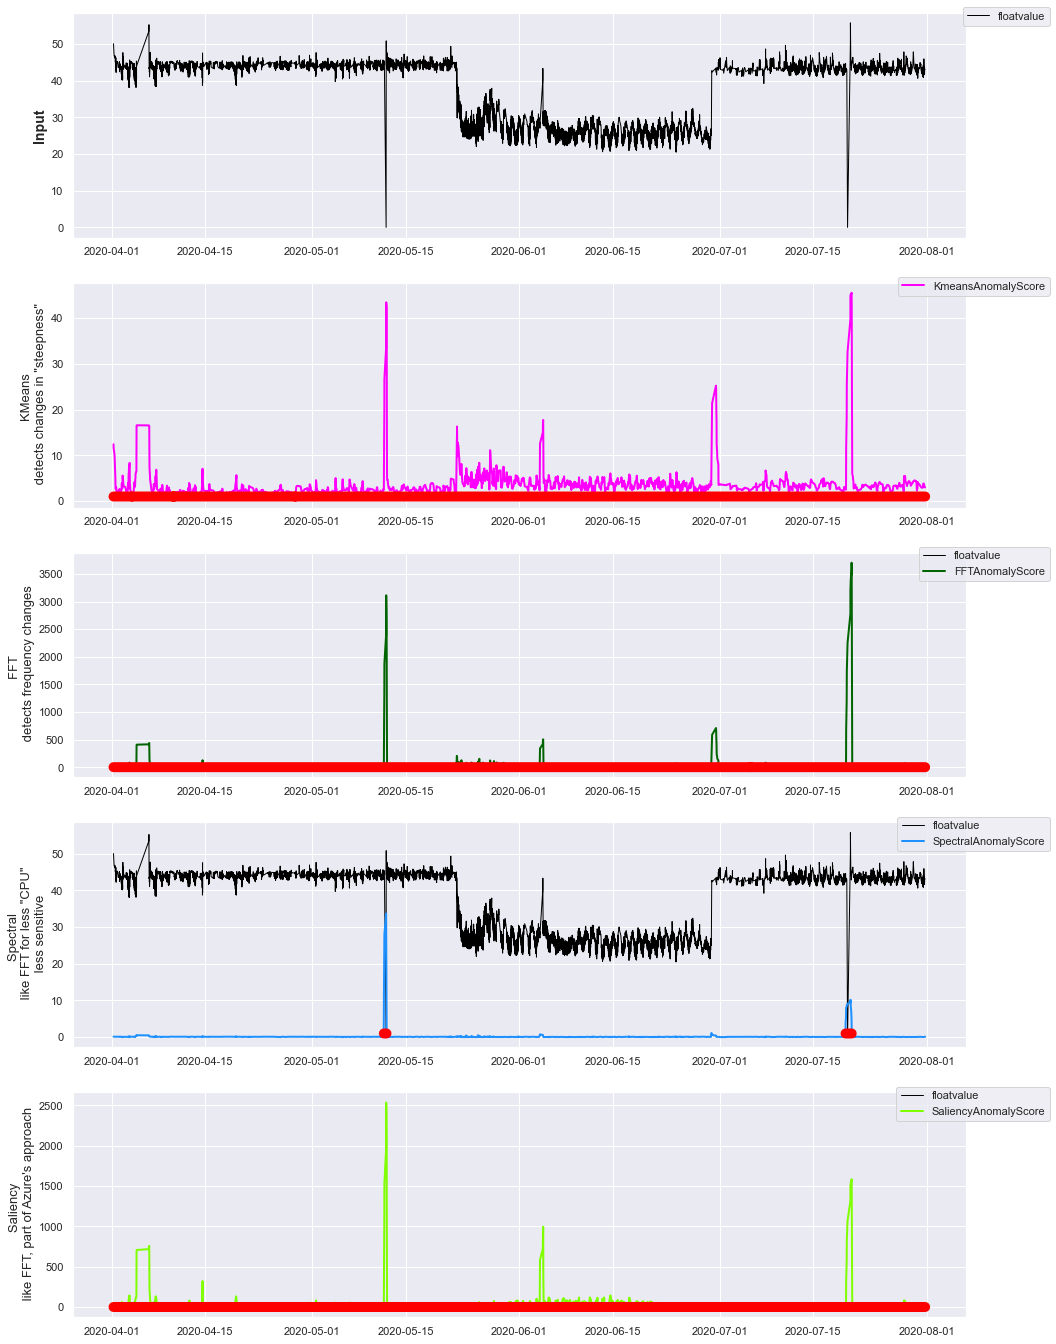

In [7]:
# Simplify dataframe to prepare input for plotting
df_plot = df_anomaly.loc[[entity]]
df_plot.reset_index(level=[0], inplace=True)
em.plot_all(df_plot)

***NEW MODEL*** <br>
**4. Matrix Profile - Anomaly Detection**

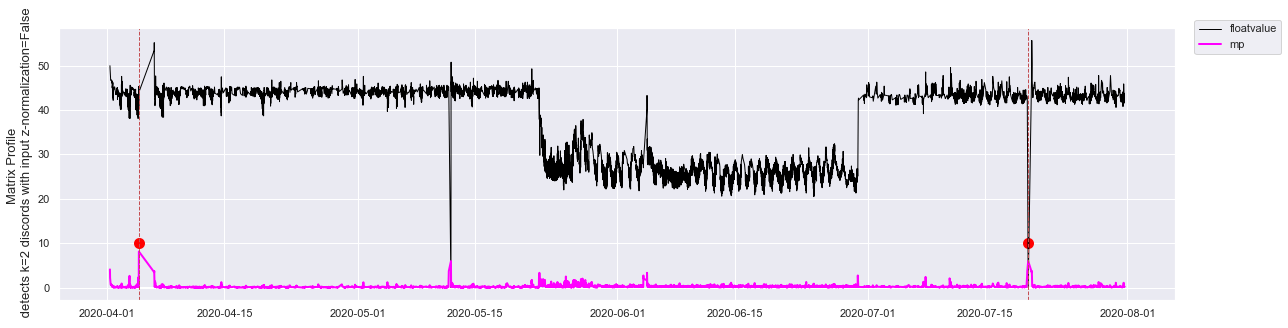

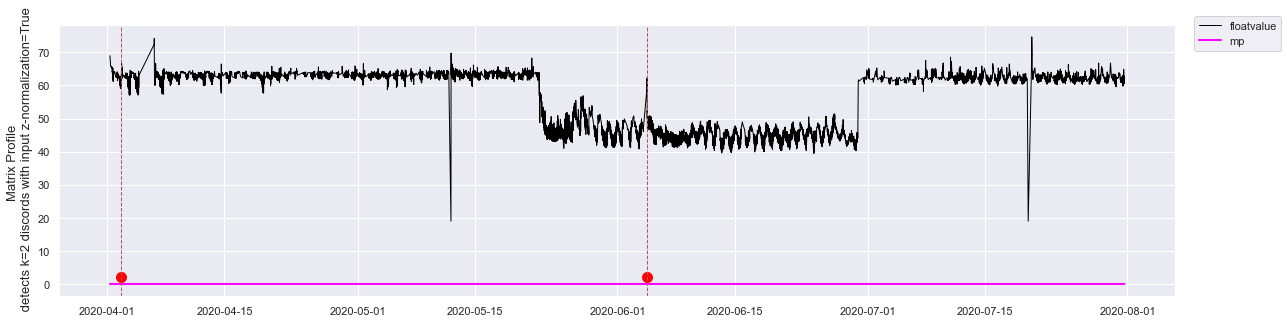

In [8]:
#Matrix Profile
window_size = 3
mp = models.MatrixProfile(df=df_i, columnname=columnname, windowsize=window_size,z_normalized=False)
mp.run_model()
df_ret = mp.plot_mp(threshold=2, columnsub=0, printdata=False, motif=False)

#Matrix Profile: z-normalized input
window_size = 3
mp_norm = models.MatrixProfile(df=df_i, columnname=columnname, windowsize=window_size,z_normalized=True)
mp_norm.run_model()
df_ret_norm = mp_norm.plot_mp(threshold=2, columnsub=-19, printdata=False, motif=False)

In [9]:
df_ret.describe()

floatvalue           mp    anomaly
count  7904.000000  7904.000000   2.000000
mean     35.428391     0.230665  10.127117
std       8.781240     0.283664   0.000000
min       0.000000     0.000000  10.127117
25%      26.500000     0.100002  10.127117
50%      41.299999     0.173205  10.127117
75%      43.700001     0.244950  10.127117
max      55.700001     8.127117  10.127117

In [10]:
df_ret_norm.describe()

floatvalue            mp   anomaly
count  7904.000000  7.904000e+03  2.000000
mean     35.428391  3.192160e-04  2.017528
std       8.781240  1.089085e-03  0.000000
min       0.000000  0.000000e+00  2.017528
25%      26.500000  3.594857e-07  2.017528
50%      41.299999  7.751469e-07  2.017528
75%      43.700001  1.938039e-06  2.017528
max      55.700001  1.752840e-02  2.017528